# 10x Genomics V(D)J Sequence Analysis Tutorial

## Overview
This tutorial is a basic walkthrough for defining B cell clonal families and building B cell lineage trees using 10x Genomics BCR sequencing data. 

Knowledge of basic command line usage is assumed. Please check out the individual documentation sites for the functions detailed in this tutorial before using them on your own data. For simplicity, this tutorial will use the [Immcantation Docker image](https://immcantation.readthedocs.io/en/stable/docker/intro.html) which contains all necessary software. It is also possible to install the packages being used separately (see [pRESTO](https://presto.readthedocs.io/en/stable/install.html#installation), [Change-O](https://changeo.readthedocs.io/en/stable/install.html#installation), and [Alakazam](https://alakazam.readthedocs.io/en/stable/install/)).


## Getting started
First, download and unzip the example data to the working directory "wk_dir".

* You will find two files (*filtered_contig.fasta* and *filtered_contig_annotations.csv*) in the working directory "wk_dir".
* The example data represents the Ig V(D)J sequences from CD19+ B cells isolated from PBMCs of a healthy human donor, and is based on data provided by 10x Genomics under a Creative Commons Attribute license, and processed with their Cell Ranger pipeline. 

Before you run the analysis pipeline, you will need to enter the Docker container and load your working directory "wk_dir" into it.

In [ ]:
singularity exec -B $wk_dir:/data immcantation_suite-4.3.0.sif bash
cd /data

After running the previous commands, you will now be in the mounted "/data" folder inside the container. 

The major steps to process 10x single cell BCR data are:

* Assigning V, D, and J genes using IgBLAST
* Filtering records
* Finding thresholds for cloning (automatically or manually)
* Defining clonal groups
* Running `CreateGermlines`
* Calculating SHM frequency in the heavy chain V genes

## Assign V, D, and J genes using IgBLAST

To process 10x V(D)J data, a combination of `AssignGenes.py` and `MakeDb.py` can be used to generate a TSV file compliant with the AIRR Community Rearrangement schema that incorporates annotation information provided by the Cell Ranger pipeline. The files of *filtered_contig.fasta* and *filtered_contig_annotations.csv*, generated by `cellranger vdj`, can be found in the "outs" directory.

Generate AIRR Rearrangement data from the 10x V(D)J FASTA files using the steps below:

In [ ]:
# Assign V, D, and J genes using IgBLAST
AssignGenes.py igblast -s /data/filtered_contig.fasta -b /usr/local/share/igblast \
   --organism human --loci ig --format blast --outdir /data

# Convert IgBLAST output to airr format
MakeDb.py igblast -i filtered_contig_igblast.fmt7 -s filtered_contig.fasta \
   -r /usr/local/share/germlines/imgt/human/vdj/imgt_human_*.fasta \
   --10x filtered_contig_annotations.csv --extended

*all_contig.fasta* can be exchanged for *filtered_contig.fasta*, and *all_contig_annotations.csv* can be exchanged for *filtered_contig_annotations.csv*.

**Warning: The resulting table overwrites the V, D and J gene assignments generated by Cell Ranger and uses those generated by IgBLAST or IMGT/HighV-QUEST instead.**

To process mouse data and/or TCR data alter the `--organism` and `--loci` arguments to `AssignGenes.py` accordingly (e.g., `--organism mouse`, `--loci tcr`) and use the appropriate V, D and J IMGT reference databases (e.g., IMGT_Mouse_TR*.fasta)

## Filtering records

The following commands in this section are meant to be entered into an R session. Open R within the Docker container using the command `R`. Once inside the R session, load the appropriate libraries and read in the data.

In [144]:
# load libraries
library(alakazam)
library(data.table)
library(dplyr)
library(scoper)
library(shazam)

setwd(file.path("C:", "Project", "Others", "Immcantation", "10x_tutorial"))

### Removing non-productive sequences

After running `AssignGenes.py` and `MakeDb.py`, you will find a file called *filtered_contig_igblast_db-pass.tsv* in your working directory. You may wish to subset your data to only productive sequences.

In [145]:
# read in data
data <- readChangeoDb('filtered_contig_igblast_db-pass.tsv')
dim(data)

data <- data %>% dplyr::filter(productive)
dim(data)

[1] 21956    57

[1] 20164    57

### Cells with multiple heavy chains

When calling clones from single cell data, if any cell in the data contains multiple heavy chains, SCOPer will throw an error message such as “xxx cell(s) with multiple heavy chains found. One heavy chain per cell is expected” and then stop running. If your data contains cells with multiple heavy chains, you need to handle it before calling clones. 

A simple solution is just removing cells with multiple heavy chains from the single cell data:

In [146]:
# remove cells with multiple heavy chain
multi_heavy <- table(dplyr::filter(data, locus == "IGH")$cell_id)
multi_heavy_cells <- names(multi_heavy)[multi_heavy > 1]

data <- dplyr::filter(data, !cell_id %in% multi_heavy_cells)
dim(data)

[1] 18393    57

### Remove cells without heavy chains

Since most of the following analyses are based on heavy chains, we remove cells without heavy chains:

In [147]:
heavy_cells <- dplyr::filter(data, locus == "IGH")$cell_id
length(heavy_cells)

light_cells <- dplyr::filter(data, locus == "IGK" | locus == "IGL")$cell_id
length(light_cells)

no_heavy_cells <- light_cells[which(!light_cells %in% heavy_cells)]
length(no_heavy_cells)

data <- dplyr::filter(data, !cell_id %in% no_heavy_cells)
dim(data)

[1] 8789

[1] 9604

[1] 227

[1] 18166    57

## Find distance threshold for cloning manually

Hierarchical clustering is a widely used distance-based method for identify clonally related sequences. An implementation of the hierarchical clustering approach is provided via the `hierachicalClones` function in SCOPer package.

It is important to determine an appropriate threshold for trimming the hierarchical clustering into B cell clones before using this method. The ideal threshold for separating clonal groups is the value that separates the two modes of the nearest-neighbor distance distribution. The nearest-neighbor distance distribution can be generated by using the `distToNearest` function in the shazam R package.

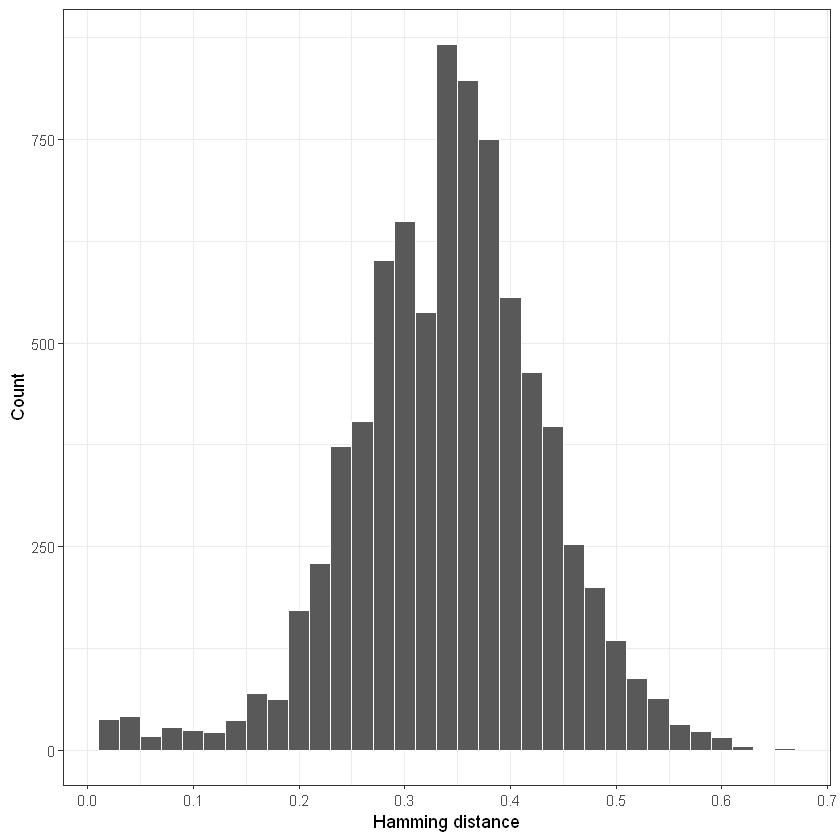

In [148]:
dist_nearest <- distToNearest(dplyr::filter(data,locus == "IGH"), 
                              sequenceColumn = "junction", 
                              vCallColumn = "v_call", jCallColumn = "j_call",
                              model = "ham", normalize = "len", 
                              nproc = 2)

# Generate Hamming distance histogram
library(ggplot2)
p1 <- ggplot(subset(dist_nearest, !is.na(dist_nearest)),
             aes(x = dist_nearest)) + 
        theme_bw() + 
        xlab("Hamming distance") + ylab("Count") +
        scale_x_continuous(breaks = seq(0, 1, 0.1)) +
        geom_histogram(color = "white", binwidth = 0.02) 
plot(p1)

The resulting distribution is often bimodal, with the first mode representing sequences with clonal relatives in the dataset and the second mode representing singletons. We can inspect the plot of nearest-neighbor distance distribution generated above to manually select a threshold to separates the two modes of the nearest-neighbor distance distribution. 

For further details regarding inferring an appropriate threshold for the hierarchical clustering method, see the [Distance to Nearest Neighbor vignette](https://shazam.readthedocs.io/en/stable/vignettes/DistToNearest-Vignette/) in the shazam package.

## Find threshold for cloning automatically

The threshold itself can be also found using the `findThreshold` function automatically. There are different ways to find the threshold and the details can be found in the [Distance to Nearest Neighbor vignette](https://shazam.readthedocs.io/en/stable/vignettes/DistToNearest-Vignette/) in the shazam package.

A robust way we suggest is to use the nearest-neighbor distance of inter (between) clones as the background and select the threshold based on the specificity of this background distribution. 

In [149]:
# Find threshold for cloning automatically
threshold_output <- findThreshold(dist_nearest$dist_nearest, 
                                  method = "gmm", model = "gamma-norm", 
                                  cutoff = "user", spc = 0.995)
threshold <- threshold_output@threshold
threshold

[1] 0.1306892

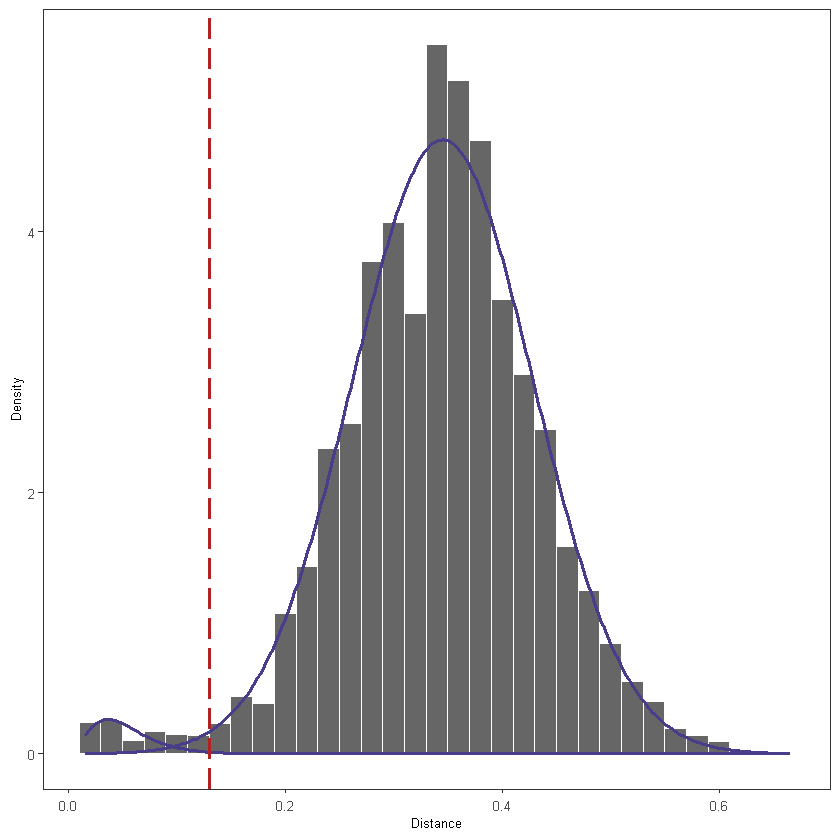

In [150]:
plot(threshold_output, binwidth = 0.02)
# plot(threshold_output, binwidth = 0.02) + ylab("Count") + xlab("Hamming distance")

The nearest-neighbor distance distribution is not always bimodal. In this case, if the data have multiple subjects, we can calculate the nearest neighbor distances across subjects to initialize the Gaussian fit parameters of the nearest-neighbor distance of inter (between) clones. 

The nearest neighbor distances across subjects can be calculated by specifying the parameter "cross" in the function `distToNearest`. And then when we call function `findThreshold`, Gaussian fit parameters can be initialized by setting parameter `cross = dist_crossSubj$cross_dist_nearest`.

In the example below, BCR data from Human CD19+ B cells of a healthy male donor aged 27 obtained by 10x Genomics from [AllCells](https://www.10xgenomics.com/resources/datasets/human-b-cells-from-a-healthy-donor-1-k-cells-2-standard-6-0-0) was used to calculate the nearest neighbor distances across subjects.

In [151]:
# read in BCR data for the second subject 
data.10xExample <- readChangeoDb('sc5p_v2_hs_B_1k_multi_5gex_b_Multiplex_vdj_b_all_contig_igblast_db-pass.tsv')
dim(data.10xExample)
which(!colnames(data) == colnames(data.10xExample)) # both files has the same columns

data$subject <- "Subj1"
data.10xExample$subject <- "Subj2"

data.2subjects <- rbind(data, data.10xExample)
dim(data.2subjects)

[1] 7060   57

integer(0)

[1] 25226    58

In [152]:
# This section for QC and may be removed ...

# check if two data sets have the same cell_id
length(intersect(data$cell_id,data.10xExample$cell_id)) 
# check if two data sets have the same seqeunces
length(intersect(data$sequence,data.10xExample$sequence))

[1] 66

[1] 28

In [153]:
# calculate cross subjects distribution of distance to nearest
dist_crossSubj <- distToNearest(dplyr::filter(data.2subjects, locus == "IGH"), 
                                sequenceColumn = "junction", 
                                vCallColumn = "v_call", jCallColumn = "j_call",
                                model = "ham", normalize = "len", 
                                nproc = 2, cross = "subject")

# Find threshold for cloning automatically and initialize the Gaussian fit parameters of the nearest-neighbor 
# distance of inter (between) clones using cross subjects distribution of distance to nearest
threshold_output <- findThreshold(dist_nearest$dist_nearest, 
                                  method = "gmm", model = "gamma-norm", 
                                  cross = dist_crossSubj$cross_dist_nearest,
                                  cutoff = "user", spc = 0.995)
threshold <- threshold_output@threshold
threshold

[1] 0.1306434

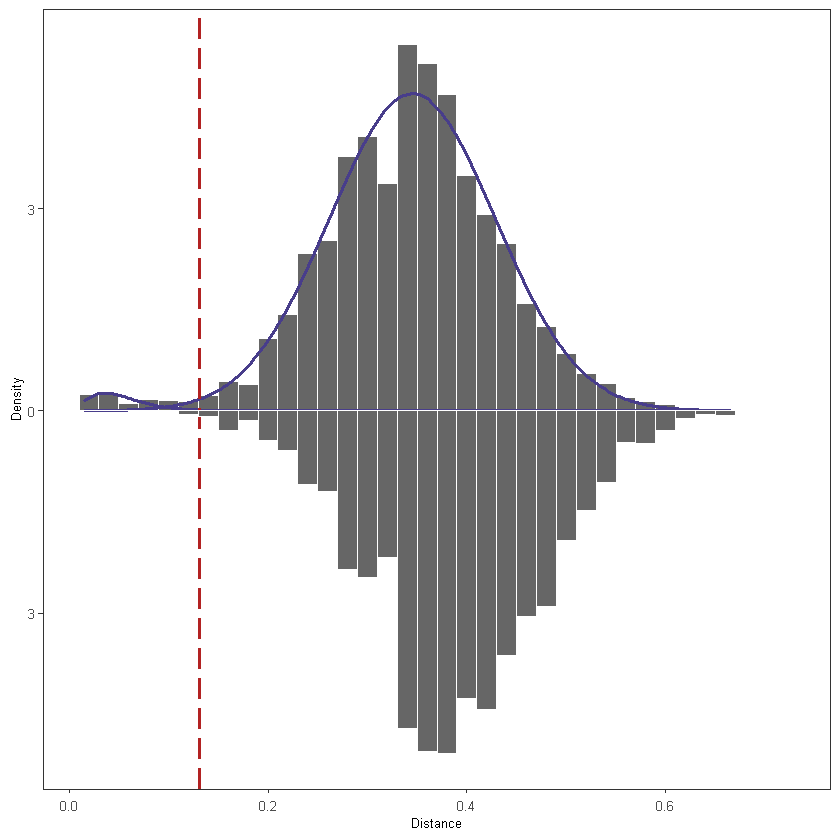

In [154]:
plot(threshold_output, binwidth = 0.02, 
     cross = dist_crossSubj$cross_dist_nearest)

In the plot above, the top plot is the nearest-neighbor distance distribution within Subj1, and the bottom plot is the nearest neighbor distances across Subj1 and Subj2.

## Define clonal groups

After we decide the threshold for calling clones, the `hierachicalClones` function in SCOPer package can be used to call clones using single cell mode:

In [155]:
# call clones using hierarchicalClones 
results <- hierarchicalClones(data, cell_id = 'cell_id', 
                              threshold = threshold, only_heavy = FALSE, 
                              split_light = TRUE, summarize_clones = FALSE)

Running defineClonesScoper in single cell mode



`HierarchicalClones` clusters B receptor sequences based on junction region sequence similarity within partitions that share the same V gene, J gene, and junction length, allowing for ambiguous V or J gene annotations. By settting up the `cell_id` parameter, `HierarchicalClones` will run in single-cell mode with paired-chain sequences. With `only_heavy = FALSE` and `split_light = TRUE`, grouping should be done by using IGH plus IGK/IGL (BCR) sequences and inferred clones should be split by the light/short chain (IGK and IGL) following heavy/long chain clustering.

After calling clones, a clonal abundance distribution can be displayed:

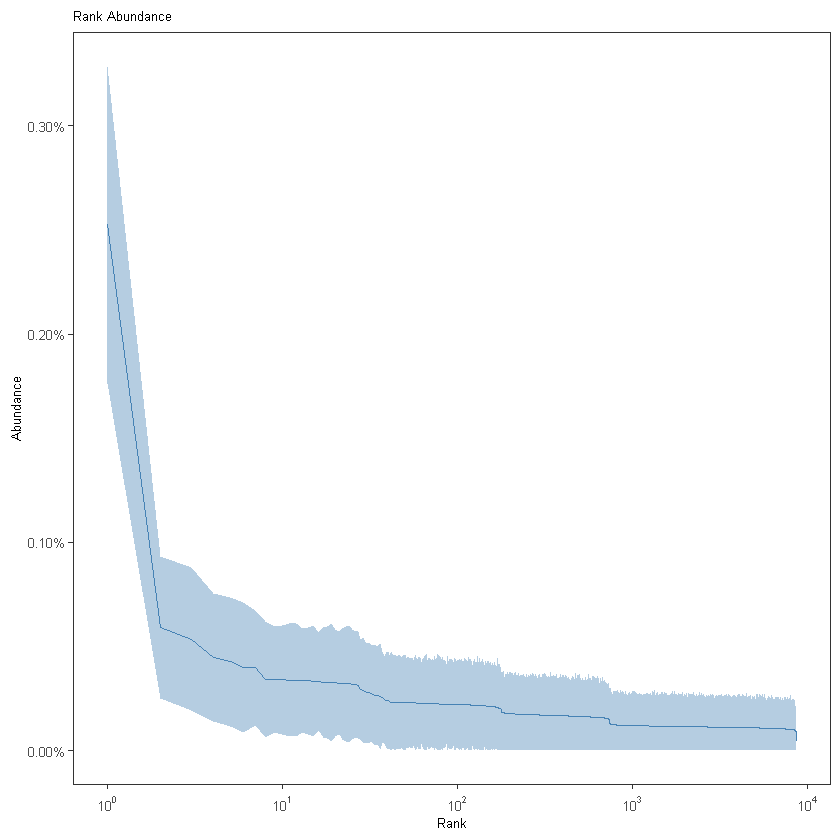

In [156]:
# calculate and plot the rank-abundance curve
plot(estimateAbundance(results), colors = "steelblue")

## Create Germlines

Before B cell lineage trees can be built, it is necessary to construct the unmutated germline sequence for each B cell clone. Typically the IGH D segment is masked because the junction region of heavy chains often cannot be reliably reconstructed.

In [157]:
library(dowser)

# Create Germlines
results <- select(results, -"germline_alignment")# remove germline_alignment generated before
references <- readIMGT(dir = "human_vdj")

h <- createGermlines(dplyr::filter(results,locus == "IGH"), references)
k <- createGermlines(dplyr::filter(results,locus == "IGK"), references, locus = "IGK")
l <- createGermlines(dplyr::filter(results,locus == "IGL"), references, locus = "IGL")

[1] "Read in 1116 from 17 fasta files"
<simpleError in buildGermline(cons, references = sub_db, seq = seq, v_call = v_call,     j_call = j_call, j_germ_length = j_germ_length, amino_acid = amino_acid,     ...): Germline sequence differs from input sequence by -5 in clone 356>
<simpleError in buildGermline(cons, references = sub_db, seq = seq, v_call = v_call,     j_call = j_call, j_germ_length = j_germ_length, amino_acid = amino_acid,     ...): Germline sequence differs from input sequence by -5 in clone 7726>


## Calculate SHM frequency in the V gene

Basic mutational load calculations can be performed by function `observedMutations` in SHazaM package.

In [158]:
# calculate SHM frequency in the V gene
data.h <- observedMutations(h, 
                            sequenceColumn = "sequence_alignment",
                            germlineColumn = "germline_alignment_d_mask",
                            regionDefinition = IMGT_V,
                            frequency = TRUE,
                            combine = TRUE, 
                            nproc = 3)

The plot below shows the distribution of median mutation frequency of clones:

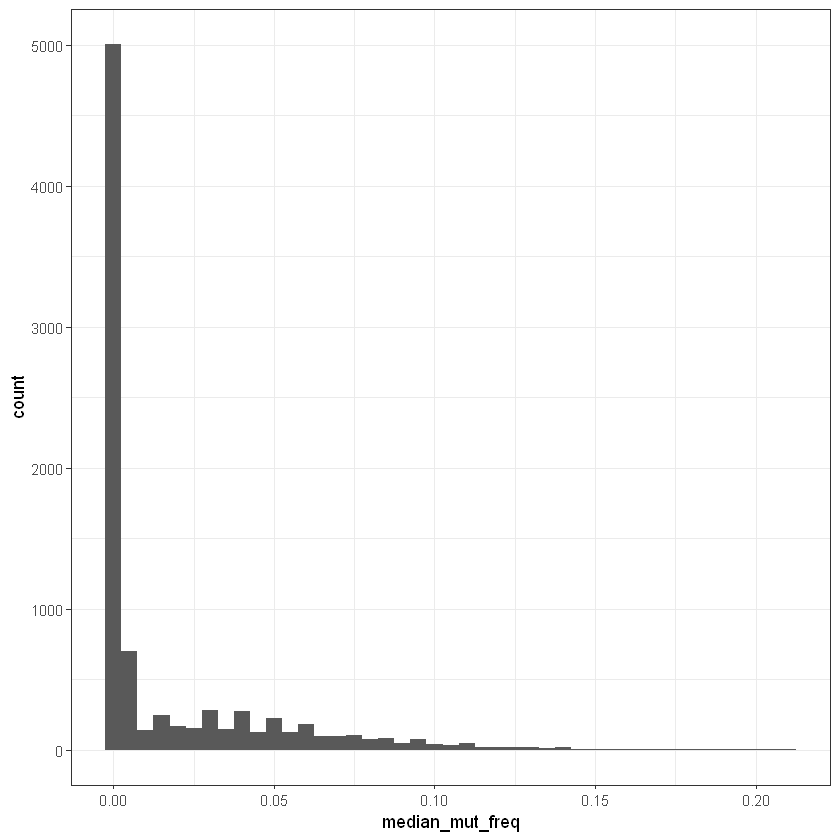

In [159]:
# calculate the median mutation frequency of a clone
mut_freq_clone <- data.h %>% 
                  group_by(clone_id) %>% 
                  summarise(median_mut_freq = mean(mu_freq))

ggplot(mut_freq_clone, aes(median_mut_freq)) + 
    geom_histogram(, binwidth = 0.005) + theme_bw()